In [33]:
import sys
import os

PROJECT_ROOT = os.path.abspath("E:/aleksa_praksa/nlp_internship/data-internship")

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)

Project root added: E:\aleksa_praksa\nlp_internship\data-internship


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from experiments.models.neural_network import prepare_nn_data, nn_classifier, nn2_classifier, train_and_evaluate_nns


In [35]:
import mlflow
import mlflow.keras
import json


mlflow.set_tracking_uri("http://127.0.0.1:5000/")

def log_nn_to_mlflow(language_name, model_name, results_dict):

    experiment_name = f"StarPrediction_NN_{language_name}"
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=model_name):

        model = results_dict["model"]
        test_accuracy = results_dict["test_accuracy"]
        class_report = results_dict["class_report"]


        mlflow.log_metric("test_accuracy", test_accuracy)

        mlflow.log_text(
            json.dumps(class_report, indent=4),
            f"{model_name}_classification_report.json"
        )

        mlflow.keras.log_model(
            model=model,
            artifact_path=f"{model_name}_model"
        )

    print(f"Logged {model_name} for {language_name} to MLflow")

In [ ]:
df = pd.read_csv("E:/aleksa_praksa/nlp_internship/data-internship/data/tokenized_dataset.csv") 

In [37]:
import ast

df['tokens'] = df['tokens'].apply(ast.literal_eval) # str to list

In [38]:
df.head()

,Unnamed: 0,stars,review_body,review_title,language,product_category,review_length,title_length,punctuation_count,all_caps_count,text,preprocessed_text,product_category_star_pred,category_book,category_digital_ebook_purchase,category_other,tokens
0,0,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports,46,25,0,0,Leider nach 1 Jahr kaputt Armband ist leider n...,Leider nach 1 Jahr kaputt Armband ist leider n...,other,0,0,1,"[Leider, nach, 1, Jahr, kaputt, Armband, ist, ..."
1,1,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement,34,24,1,0,EINS statt ZWEI Akkus!!! In der Lieferung war ...,EINS statt ZWEI Akkus!!! In der Lieferung war ...,other,0,0,1,"[EINS, statt, ZWEI, Akkus, !, !, !, In, der, L..."
2,2,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore,384,15,0,0,"Achtung Abzocke Ein Stern, weil gar keine geht...","Achtung Abzocke Ein Stern, weil gar keine geht...",other,0,0,1,"[Achtung, Abzocke, Ein, Stern, weil, gar, kein..."
3,3,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore,205,17,0,0,"Zu viel des Guten Dachte, das wären einfach et...","Zu viel des Guten Dachte, das wären einfach et...",other,0,0,1,"[Zu, viel, des, Guten, Dachte, das, wären, ein..."
4,4,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy,114,22,0,0,Qualität sehr schlecht Meine Kinder haben kaum...,Qualität sehr schlecht Meine Kinder haben kaum...,other,0,0,1,"[Qualität, sehr, schlecht, Meine, Kinder, habe..."


In [ ]:
def split_language_df(df_one_language): 
    return train_test_split(df_one_language[['tokens']], df_one_language['stars'], test_size = 0.2, stratify = df_one_language['stars'], random_state = 42)

In [40]:
# English
X_train_en, X_test_en, y_train_en, y_test_en = split_language_df(df[df['language'] == 'en'])

# German
X_train_de, X_test_de, y_train_de, y_test_de = split_language_df(df[df['language'] == 'de'])

# France
X_train_fr, X_test_fr, y_train_fr, y_test_fr = split_language_df(df[df['language'] == 'fr'])

# Spansih
X_train_es, X_test_es, y_train_es, y_test_es = split_language_df(df[df['language'] == 'fr'])

In [41]:
X_test_fr.head()

,tokens
612731,"[Chaud, et, bien, taillé, Très, bonne, paire, ..."
553462,"[Livraison, et, produits, parfaits, Comme, pro..."
517477,"[100, huile, de, nigelle, ?, ?, ?, ?, ?, ?, Je..."
546631,"[Nickel, Super, pr, les, tablettes, pas, déçu, !]"
625352,"[erreur, référencement, commande, pour, redmi,..."


➡️ Important:
TF-IDF does not store word order. To TF-IDF “very good product” are “good product very” are exactly the same vector.

| word vocab | very | not | good | product |
| ---------- | ---- | --- | ---- | ------- |
| sentence 1 | 1    | 0   | 1    | 1       |
| sentence 2 | 0    | 1   | 1    | 1       |

TF-IDF vectors: 
- are huge (50k–100k dimensions)

- are sparse (mostly zeros)

- have no spatial or temporal meaning

For NN
"very good product" → [12, 45, 891]
"not good product"  → [77, 45, 891]

Using TF-IDF with a neural network removes the main advantage of neural networks: learning from sequences.

In [42]:
# English
X_train_pad_en, X_test_pad_en, y_train_nn_en, y_test_nn_en, tokenizer_en = prepare_nn_data(X_train_en, X_test_en, y_train_en, y_test_en)

# German
X_train_pad_de, X_test_pad_de, y_train_nn_de, y_test_nn_de, tokenizer_de = prepare_nn_data(X_train_de, X_test_de, y_train_de, y_test_de)

# French
X_train_pad_fr, X_test_pad_fr, y_train_nn_fr, y_test_nn_fr, tokenizer_fr = prepare_nn_data(X_train_fr, X_test_fr, y_train_fr, y_test_fr)

# Spanish
X_train_pad_es, X_test_pad_es, y_train_nn_es, y_test_nn_es, tokenizer_es = prepare_nn_data(X_train_es, X_test_es, y_train_es, y_test_es)


In [43]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience = 5,
        restore_best_weights=True
    )
]


Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


561/561 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.4348 - loss: 1.2786 - val_accuracy: 0.5285 - val_loss: 1.0841
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 39s 70ms/step - accuracy: 0.5494 - loss: 1.0573 - val_accuracy: 0.5388 - val_loss: 1.0904
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.5748 - loss: 1.0032 - val_accuracy: 0.5626 - val_loss: 1.0229
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.5930 - loss: 0.9670 - val_accuracy: 0.5737 - val_loss: 1.0075
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 85s 82ms/step - accuracy: 0.6082 - loss: 0.9394 - val_accuracy: 0.5510 - val_loss: 1.0092
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.6211 - loss: 0.9116 - val_accuracy: 0.5694 - val_loss: 0.9837
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.6286 - loss: 0.8979 - val_accuracy: 0.5666 - val_loss: 1.0263
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.6346 - loss: 0.8837 - val_accurac

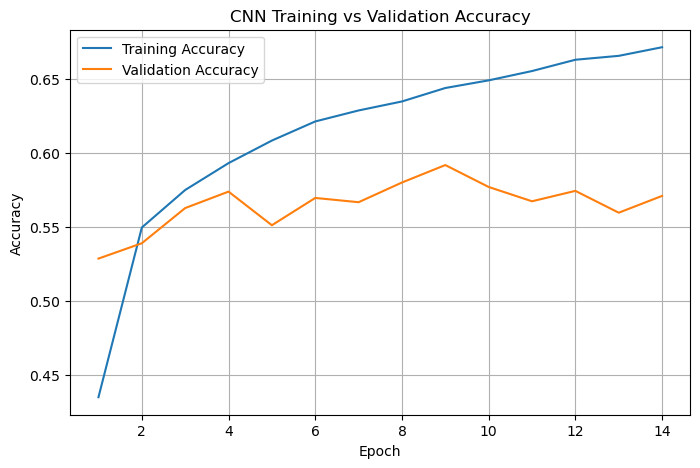

{'0': {'precision': 0.6417718810186176, 'recall': 0.7534229368169828, 'f1-score': 0.693129947420119, 'support': 7961.0}, '1': {'precision': 0.4972021291115054, 'recall': 0.4572038152610442, 'f1-score': 0.4763648251062439, 'support': 7968.0}, '2': {'precision': 0.5407608695652174, 'recall': 0.4, 'f1-score': 0.45984979780473717, 'support': 7960.0}, '3': {'precision': 0.5478730409587779, 'recall': 0.5217609431832434, 'f1-score': 0.5344982654503405, 'support': 7973.0}, '4': {'precision': 0.6782725488170266, 'recall': 0.8236105883828879, 'f1-score': 0.7439093484419264, 'support': 7971.0}, 'accuracy': 0.5912183365551176, 'macro avg': {'precision': 0.581176093894229, 'recall': 0.5911996567288316, 'f1-score': 0.5815504368446733, 'support': 39833.0}, 'weighted avg': {'precision': 0.5811766945365319, 'recall': 0.5912183365551176, 'f1-score': 0.5815615925300627, 'support': 39833.0}}


In [44]:
nn_model_en  = nn_classifier()

results_nn_en = train_and_evaluate_nns(nn_model_en , X_train_pad_en, y_train_nn_en, X_test_pad_en, y_test_nn_en, epochs = 15, batch_size = 256, validation_split = 0.1, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


509/509 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.4181 - loss: 1.3011 - val_accuracy: 0.5441 - val_loss: 1.0581
Epoch 2/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.5414 - loss: 1.0534 - val_accuracy: 0.5493 - val_loss: 1.0390
Epoch 3/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.5670 - loss: 1.0005 - val_accuracy: 0.5252 - val_loss: 1.0849
Epoch 4/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.5871 - loss: 0.9648 - val_accuracy: 0.5072 - val_loss: 1.1367
Epoch 5/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.5951 - loss: 0.9448 - val_accuracy: 0.5513 - val_loss: 1.0269
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


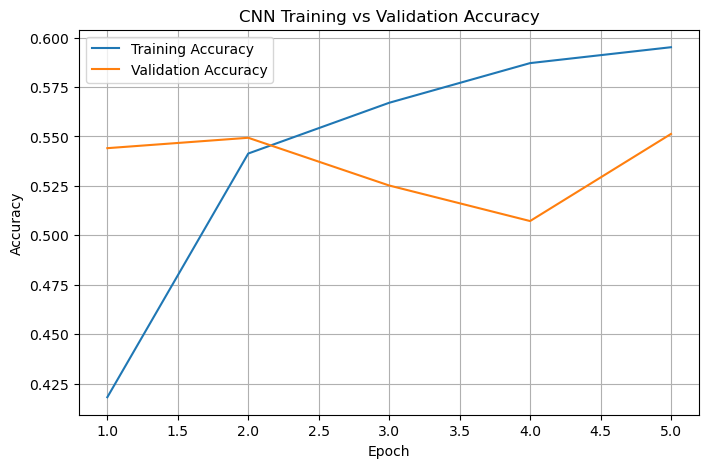

{'0': {'precision': 0.5856694560669456, 'recall': 0.773022228358415, 'f1-score': 0.6664286139379872, 'support': 7243.0}, '1': {'precision': 0.42817396397715624, 'recall': 0.40297684674751927, 'f1-score': 0.415193468228612, 'support': 7256.0}, '2': {'precision': 0.4575285955372211, 'recall': 0.33851276359600446, 'f1-score': 0.3891236743481381, 'support': 7208.0}, '3': {'precision': 0.5131132917038359, 'recall': 0.39844832363535604, 'f1-score': 0.448568977618342, 'support': 7218.0}, '4': {'precision': 0.6553172171149699, 'recall': 0.8004990988492999, 'f1-score': 0.7206689965052422, 'support': 7213.0}, 'accuracy': 0.5427251093032265, 'macro avg': {'precision': 0.5279605048800258, 'recall': 0.5426918522373189, 'f1-score': 0.5279967461276642, 'support': 36138.0}, 'weighted avg': {'precision': 0.5278973683134647, 'recall': 0.5427251093032265, 'f1-score': 0.5279856675289871, 'support': 36138.0}}


In [45]:
nn_model_de = nn_classifier()
results_nn_de = train_and_evaluate_nns(nn_model_de,X_train_pad_de, y_train_nn_de,X_test_pad_de,  y_test_nn_de,epochs=15, batch_size=256, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.3693 - loss: 1.3837 - val_accuracy: 0.4910 - val_loss: 1.1572
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.5128 - loss: 1.1047 - val_accuracy: 0.5225 - val_loss: 1.0712
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.5425 - loss: 1.0440 - val_accuracy: 0.3882 - val_loss: 1.6334
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.5535 - loss: 1.0265 - val_accuracy: 0.3259 - val_loss: 2.3548
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5581 - loss: 1.0253 - val_accuracy: 0.2899 - val_loss: 2.8018
867/867 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


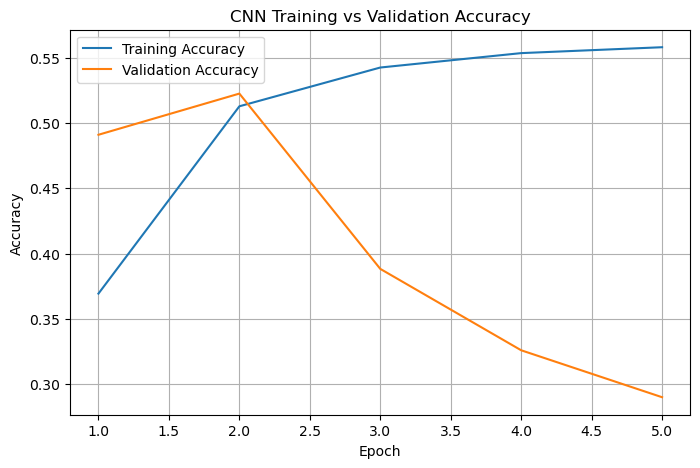

{'0': {'precision': 0.7066293585880327, 'recall': 0.5920649233543733, 'f1-score': 0.6442939848886272, 'support': 5545.0}, '1': {'precision': 0.4481962481962482, 'recall': 0.2802237459400938, 'f1-score': 0.3448428999666926, 'support': 5542.0}, '2': {'precision': 0.37924807092431456, 'recall': 0.4171180931744312, 'f1-score': 0.39728265543038954, 'support': 5538.0}, '3': {'precision': 0.35454545454545455, 'recall': 0.3993174061433447, 'f1-score': 0.3756019261637239, 'support': 5567.0}, '4': {'precision': 0.5782734407269723, 'recall': 0.757712430092008, 'f1-score': 0.6559425269404966, 'support': 5543.0}, 'accuracy': 0.4892374256354786, 'macro avg': {'precision': 0.49337851459620446, 'recall': 0.48928731974085016, 'f1-score': 0.48359279867798594, 'support': 27735.0}, 'weighted avg': {'precision': 0.4932959598001534, 'recall': 0.4892374256354786, 'f1-score': 0.4835315014739849, 'support': 27735.0}}


In [46]:
nn_model_fr = nn_classifier()
results_nn_fr = train_and_evaluate_nns(nn_model_fr,X_train_pad_fr, y_train_nn_fr,X_test_pad_fr,  y_test_nn_fr,epochs=15, batch_size=256, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.3672 - loss: 1.3867 - val_accuracy: 0.4388 - val_loss: 1.2704
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.5128 - loss: 1.1039 - val_accuracy: 0.4849 - val_loss: 1.1746
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.5401 - loss: 1.0502 - val_accuracy: 0.5319 - val_loss: 1.0528
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.5570 - loss: 1.0177 - val_accuracy: 0.5462 - val_loss: 1.0291
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.5733 - loss: 0.9862 - val_accuracy: 0.4047 - val_loss: 1.4230
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step


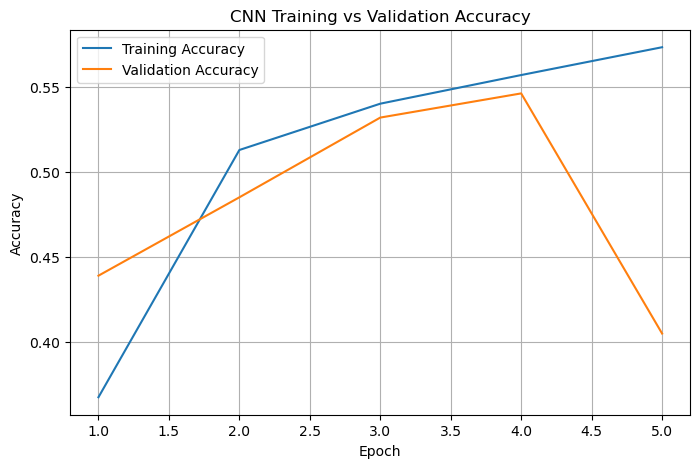

{'0': {'precision': 0.7825278810408922, 'recall': 0.37962128043282234, 'f1-score': 0.5112325440194293, 'support': 5545.0}, '1': {'precision': 0.4121457489878543, 'recall': 0.2755322988090942, 'f1-score': 0.3302692765221153, 'support': 5542.0}, '2': {'precision': 0.33731235304756735, 'recall': 0.33676417479234383, 'f1-score': 0.3370380410228608, 'support': 5538.0}, '3': {'precision': 0.29728661749209695, 'recall': 0.4054248248607868, 'f1-score': 0.3430351850444563, 'support': 5567.0}, '4': {'precision': 0.5396033580727583, 'recall': 0.8001082446328703, 'f1-score': 0.644528411568086, 'support': 5543.0}, 'accuracy': 0.4394808004326663, 'macro avg': {'precision': 0.47377519172823385, 'recall': 0.43949016470558344, 'f1-score': 0.4332206916353895, 'support': 27735.0}, 'weighted avg': {'precision': 0.47367155816894413, 'recall': 0.4394808004326663, 'f1-score': 0.4331693282394913, 'support': 27735.0}}


In [47]:
nn_model_es = nn_classifier()
results_nn_es = train_and_evaluate_nns(nn_model_es,X_train_pad_es, y_train_nn_es,X_test_pad_es,  y_test_nn_es,epochs=15, batch_size=256, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


561/561 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.3659 - loss: 1.3822 - val_accuracy: 0.5380 - val_loss: 1.0794
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.5399 - loss: 1.0763 - val_accuracy: 0.5399 - val_loss: 1.0429
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.5649 - loss: 1.0249 - val_accuracy: 0.5775 - val_loss: 0.9856
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.5829 - loss: 0.9838 - val_accuracy: 0.5903 - val_loss: 0.9594
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.5950 - loss: 0.9595 - val_accuracy: 0.5755 - val_loss: 0.9955
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.6009 - loss: 0.9420 - val_accuracy: 0.5834 - val_loss: 0.9734
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - accuracy: 0.6122 - loss: 0.9207 - val_accuracy: 0.5524 - val_loss: 1.0352
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.6170 - loss: 0.9084 - val_accurac

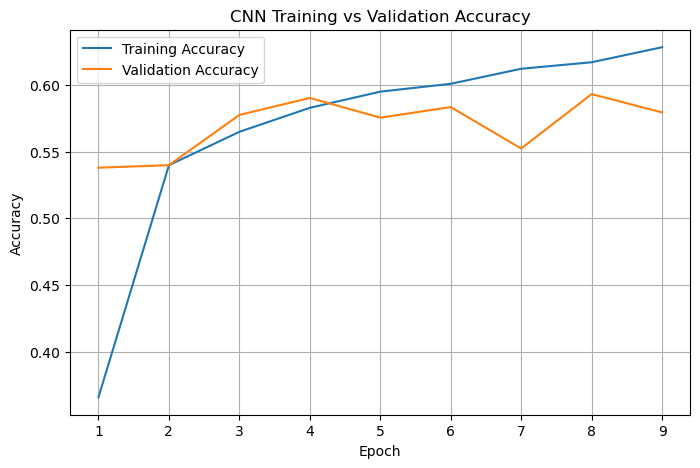

{'0': {'precision': 0.6609247506799637, 'recall': 0.7325712850144455, 'f1-score': 0.6949061662198391, 'support': 7961.0}, '1': {'precision': 0.4580756863715063, 'recall': 0.464859437751004, 'f1-score': 0.4614426311199701, 'support': 7968.0}, '2': {'precision': 0.4942111870553773, 'recall': 0.44510050251256283, 'f1-score': 0.46837200079317864, 'support': 7960.0}, '3': {'precision': 0.565709435563729, 'recall': 0.5015677912956227, 'f1-score': 0.5317112086158755, 'support': 7973.0}, '4': {'precision': 0.7144502014968336, 'recall': 0.7784468699033998, 'f1-score': 0.7450768491834774, 'support': 7971.0}, 'accuracy': 0.5845153515929004, 'macro avg': {'precision': 0.578674252233482, 'recall': 0.5845091772954069, 'f1-score': 0.5803017711864682, 'support': 39833.0}, 'weighted avg': {'precision': 0.5786853599782349, 'recall': 0.5845153515929004, 'f1-score': 0.5803104217982485, 'support': 39833.0}}


In [48]:
nn2_model_en = nn2_classifier()
results_nn2_en = train_and_evaluate_nns(nn2_model_en, X_train_pad_en, y_train_nn_en, X_test_pad_en, y_test_nn_en, epochs = 15, batch_size = 256, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


509/509 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.3569 - loss: 1.3823 - val_accuracy: 0.5098 - val_loss: 1.1174
Epoch 2/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.5324 - loss: 1.0730 - val_accuracy: 0.5445 - val_loss: 1.0498
Epoch 3/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step - accuracy: 0.5575 - loss: 1.0225 - val_accuracy: 0.5501 - val_loss: 1.0089
Epoch 4/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.5723 - loss: 0.9940 - val_accuracy: 0.4770 - val_loss: 1.1396
Epoch 5/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.5855 - loss: 0.9645 - val_accuracy: 0.5447 - val_loss: 1.0221
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


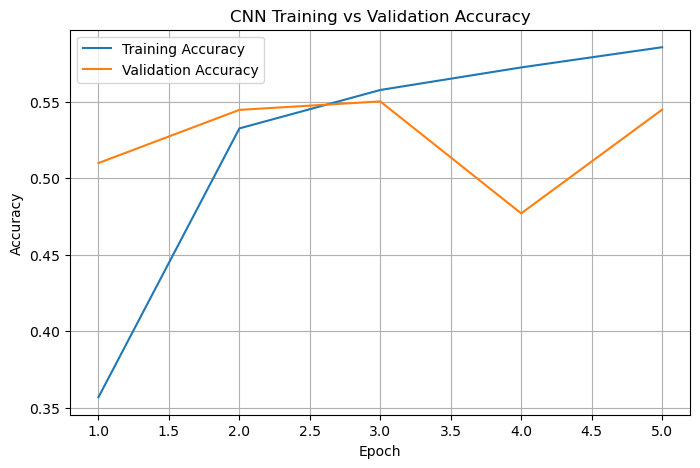

{'0': {'precision': 0.6939293073387225, 'recall': 0.6044456716830042, 'f1-score': 0.6461038961038961, 'support': 7243.0}, '1': {'precision': 0.40297624913767616, 'recall': 0.5635336273428887, 'f1-score': 0.46991897948629546, 'support': 7256.0}, '2': {'precision': 0.3789146289146289, 'recall': 0.490149833518313, 'f1-score': 0.4274135010887975, 'support': 7208.0}, '3': {'precision': 0.4800230503265463, 'recall': 0.3462177888611804, 'f1-score': 0.40228589826142946, 'support': 7218.0}, '4': {'precision': 0.7630046583850931, 'recall': 0.5449882157216137, 'f1-score': 0.6358269308532147, 'support': 7213.0}, 'accuracy': 0.5099894847528917, 'macro avg': {'precision': 0.5437695788205333, 'recall': 0.5098670274253999, 'f1-score': 0.5163098411587267, 'support': 36138.0}, 'weighted avg': {'precision': 0.5437406956722198, 'recall': 0.5099894847528917, 'f1-score': 0.5163589135086715, 'support': 36138.0}}


In [49]:
nn2_model_de = nn2_classifier()
results_nn2_de = train_and_evaluate_nns(nn2_model_de, X_train_pad_de, y_train_nn_de, X_test_pad_de, y_test_nn_de, epochs = 15, batch_size = 256, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.3143 - loss: 1.4468 - val_accuracy: 0.3766 - val_loss: 1.3121
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.4904 - loss: 1.1467 - val_accuracy: 0.3746 - val_loss: 1.6072
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.5241 - loss: 1.0812 - val_accuracy: 0.4593 - val_loss: 1.1952
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.5401 - loss: 1.0490 - val_accuracy: 0.4495 - val_loss: 1.1813
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5606 - loss: 1.0094 - val_accuracy: 0.3713 - val_loss: 1.4378
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


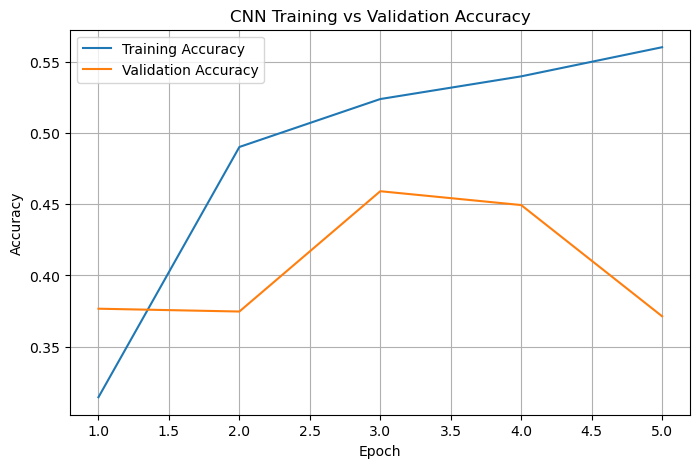

{'0': {'precision': 0.7982126058325494, 'recall': 0.3060414788097385, 'f1-score': 0.44244557424064657, 'support': 5545.0}, '1': {'precision': 0.3754492673486315, 'recall': 0.49007578491519305, 'f1-score': 0.42517219787100813, 'support': 5542.0}, '2': {'precision': 0.2940923737916219, 'recall': 0.7416034669555797, 'f1-score': 0.42116597446546683, 'support': 5538.0}, '3': {'precision': 0.3490170802449243, 'recall': 0.1945392491467577, 'f1-score': 0.24982698961937716, 'support': 5567.0}, '4': {'precision': 0.7276205049732212, 'recall': 0.17156774309940465, 'f1-score': 0.2776642335766423, 'support': 5543.0}, 'accuracy': 0.3805300162249865, 'macro avg': {'precision': 0.5088783664381896, 'recall': 0.38076554458533474, 'f1-score': 0.36325499395462824, 'support': 27735.0}, 'weighted avg': {'precision': 0.5088044294153835, 'recall': 0.3805300162249865, 'f1-score': 0.3631498790078121, 'support': 27735.0}}


In [50]:
nn2_model_fr = nn2_classifier()
results_nn2_fr = train_and_evaluate_nns(nn2_model_fr, X_train_pad_fr, y_train_nn_fr, X_test_pad_fr, y_test_nn_fr, epochs = 15, batch_size = 256, callbacks = callbacks)

Epoch 1/15


c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.3018 - loss: 1.4652 - val_accuracy: 0.4176 - val_loss: 1.2354
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.4840 - loss: 1.1521 - val_accuracy: 0.4664 - val_loss: 1.1596
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.5282 - loss: 1.0738 - val_accuracy: 0.5386 - val_loss: 1.0462
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.5482 - loss: 1.0338 - val_accuracy: 0.4802 - val_loss: 1.2280
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5537 - loss: 1.0249 - val_accuracy: 0.4017 - val_loss: 1.9307
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


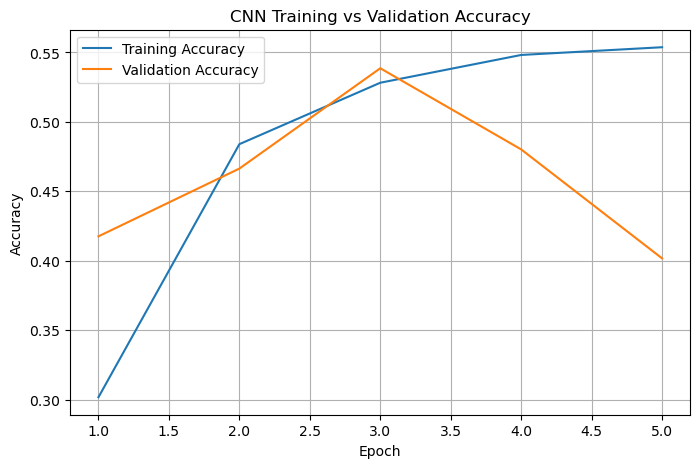

{'0': {'precision': 0.8163756773028297, 'recall': 0.24454463480613164, 'f1-score': 0.37635303913405493, 'support': 5545.0}, '1': {'precision': 0.3557439935392691, 'recall': 0.31793576326236017, 'f1-score': 0.33577894235350164, 'support': 5542.0}, '2': {'precision': 0.3285841495992876, 'recall': 0.6663055254604551, 'f1-score': 0.4401240458015267, 'support': 5538.0}, '3': {'precision': 0.4164310398994659, 'recall': 0.4761990299982037, 'f1-score': 0.44431408698567, 'support': 5567.0}, '4': {'precision': 0.6609929078014184, 'recall': 0.42034999097961395, 'f1-score': 0.513895015438906, 'support': 5543.0}, 'accuracy': 0.4250585902289526, 'macro avg': {'precision': 0.5156255536284541, 'recall': 0.42506698890135286, 'f1-score': 0.4220930259427319, 'support': 27735.0}, 'weighted avg': {'precision': 0.5156008887825225, 'recall': 0.4250585902289526, 'f1-score': 0.42210881770316844, 'support': 27735.0}}


In [51]:
nn2_model_es = nn2_classifier()
results_nn2_es = train_and_evaluate_nns(nn2_model_es, X_train_pad_es, y_train_nn_es, X_test_pad_es, y_test_nn_es, epochs = 15, batch_size = 256, callbacks = callbacks)

In [52]:
log_nn_to_mlflow("English", "NN", results_nn_en)
log_nn_to_mlflow("English", "NN2", results_nn2_en)

log_nn_to_mlflow("German", "NN",  results_nn_de)
log_nn_to_mlflow("German", "NN2", results_nn2_de)

log_nn_to_mlflow("French", "NN",  results_nn_fr)
log_nn_to_mlflow("French", "NN2", results_nn2_fr)

log_nn_to_mlflow("Spanish", "NN",  results_nn_es)
log_nn_to_mlflow("Spanish", "NN2", results_nn2_es)


2025/11/24 17:02:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/24 17:02:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:02:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/24 17:02:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run NN at: http://127.0.0.1:5000/#/experiments/372045236376882417/runs/9b6f6f193dc64c7793df29d84fc3967f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/372045236376882417
Logged NN for English to MLflow


2025/11/24 17:02:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:03:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/24 17:03:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run NN2 at: http://127.0.0.1:5000/#/experiments/372045236376882417/runs/f95d3ab5a4ce4856b98273b7d3582a01
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/372045236376882417
Logged NN2 for English to MLflow


2025/11/24 17:03:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:03:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/24 17:03:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run NN at: http://127.0.0.1:5000/#/experiments/127404309333274524/runs/6ba855b3f7af4c74845dc1d577606d56
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/127404309333274524
Logged NN for German to MLflow


2025/11/24 17:03:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:03:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/24 17:03:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run NN2 at: http://127.0.0.1:5000/#/experiments/127404309333274524/runs/1457a7bda51947148f68a592d208db3f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/127404309333274524
Logged NN2 for German to MLflow


2025/11/24 17:03:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:03:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run NN at: http://127.0.0.1:5000/#/experiments/658706268274729254/runs/590571ee64d54d5590818345a01fcc71
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/658706268274729254
Logged NN for French to MLflow


2025/11/24 17:03:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/24 17:03:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:03:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/24 17:04:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run NN2 at: http://127.0.0.1:5000/#/experiments/658706268274729254/runs/f83ef2ee84a249958867602c309271bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/658706268274729254
Logged NN2 for French to MLflow


2025/11/24 17:04:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:04:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/24 17:04:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run NN at: http://127.0.0.1:5000/#/experiments/867379280638250254/runs/ef19fded501c4c3281d42c3a6bcafbde
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/867379280638250254
Logged NN for Spanish to MLflow


2025/11/24 17:04:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/24 17:04:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run NN2 at: http://127.0.0.1:5000/#/experiments/867379280638250254/runs/26a5169e0de041f596301fab38595643
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/867379280638250254
Logged NN2 for Spanish to MLflow
